## Jean Batista's Stock Portfolio
#### Welcome to my first weighted portfolio. Made with code that does all the calculations for me.
#### This project uses python code, first getting data from Yahoo Finance, and then runs a series of formulas.
#### They have been researched and submitted as accurate predictors for growth by legitimate financial researchers in the quant-finance space.
#### The result of the formulas is taken to select a group of 10 stocks out of the 500 in the S & P 500.
#### These ten stocks make up my portfolio.
#### But the share percent of each stock is not an equal 10%
#### Instead, I use an algorithm called Monte-Carlo Simulations.
#### This runs different combinations of shares percent for each stock, hundreds of thousands of times.
#### Ultimately selecting the combination of each stock's share percent that output the highest expected growth.

#### My stock portfolio's growth is calculated everyday and fed into an API that sends the information to my website, so that I and other people can easily view its progress over time.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import os
import sys
import plotly
import plotly.graph_objs as go

In [2]:
# The SP500 is the benchmark, its updated 500 stocks are sourced from the official daily-updated csv from the State Street Global Advisors website.
# List of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['-', 'BRK.B', '2481632D']: Exception('%ticker%: No data found, symbol may be delisted')


In [3]:
# Changing the time period and lag will affect the range of the alortithm
time_period = 1260  # 5 years of trading days. (252 trading days per year)
lag = 20 # lag of 20 trading days (1 month)


## First part of the formula :Momentum Factors
####  Itterates calculations for each of the 500 stocks in the S & P 500.


In [4]:
#how_many_days_back = 0 for current, 1260 for 5 years.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors Result


In [5]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.054198,38.557715,6.411695,0.140670,2.549694e+05
AAPL,0.113578,47.905910,11.115414,0.246927,2.675737e+07
ABBV,0.089223,37.347081,10.032974,0.189444,2.663842e+04
ABNB,NaN,35.730269,-1.728853,0.007969,1.365186e+06
ABT,0.026803,26.406967,3.062247,0.071702,1.138446e+06
...,...,...,...,...,...
XYL,0.049647,44.935013,7.991216,0.148475,-2.311496e+05
YUM,0.045201,32.058599,5.717147,0.090769,1.616275e+05
ZBH,-0.004978,28.296330,-0.264771,0.008625,-1.524901e+05


## Z-Score normalizes the data results
### Our portfolio basket is determined by the highest and lowest scores, resulted from the momentum factor calculations.

In [6]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
NVDA    33.660250
SMCI    22.212864
TSLA    20.902877
NVR     17.106505
MRNA    12.073864
BLDR     9.312348
CRWD     9.200657
TRGP     9.016032
ENPH     8.830188
AZO      8.469572
dtype: float64

Short Basket:
Ticker
INTC   -4.916593
TFX    -5.107865
INCY   -5.119536
CHTR   -5.212813
FIS    -5.389781
MKTX   -5.539442
KVUE   -5.622255
WBD    -6.118201
WBA    -6.198888
BAX    -6.483533
dtype: float64


## Back Test

In [7]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
AMD     19.908038
NVR     18.993638
ENPH    17.007424
NVDA    14.956161
CZR     11.340095
PAYC    11.246664
NFLX    10.658578
ALGN     9.993617
DAY      7.231217
MTCH     7.205970
dtype: float64
Short Basket Past 5 Years:
Ticker
GILD   -5.532152
BIIB   -5.610567
CVS    -5.913020
CAH    -5.982100
KHC    -6.165359
SLB    -6.215942
MCK    -6.560119
GE     -6.903035
EQT    -6.925528
VTRS   -7.160036
dtype: float64


## Graphing Cumulative Returns

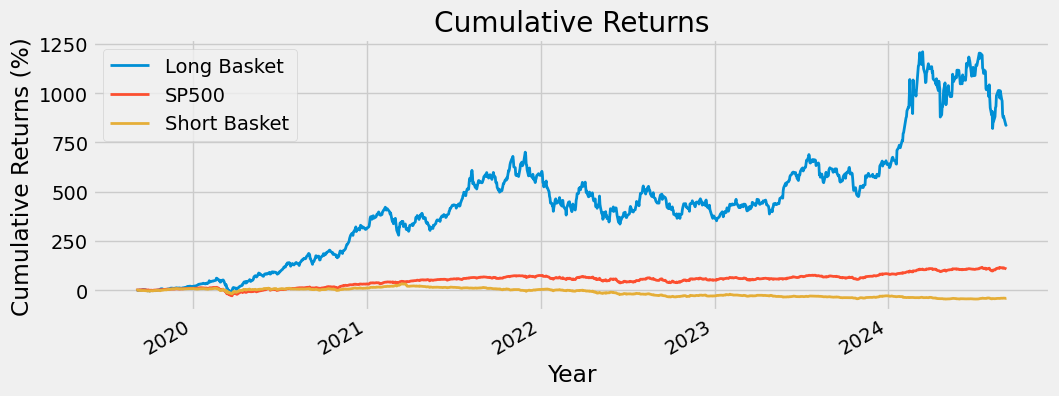

In [8]:
def calculate_cumulative_returns(dataf):
    # Calculate percentage change
    returns = dataf.pct_change()
    # Initialize the first value to 1 (i.e., no change, or 0% return)
    # This is achieved by filling the NaN values resulted from pct_change() with 0
    # and then adding 1 to convert the initial value to 1 for cumprod() calculation
    cumulative_returns = (1 + returns.fillna(0)).cumprod().mean(axis=1)*100
    # To start from 0%, subtract 100 from the entire series
    cumulative_returns = cumulative_returns - 100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Portfolio stats -- Equally weighted (not final portfolio)

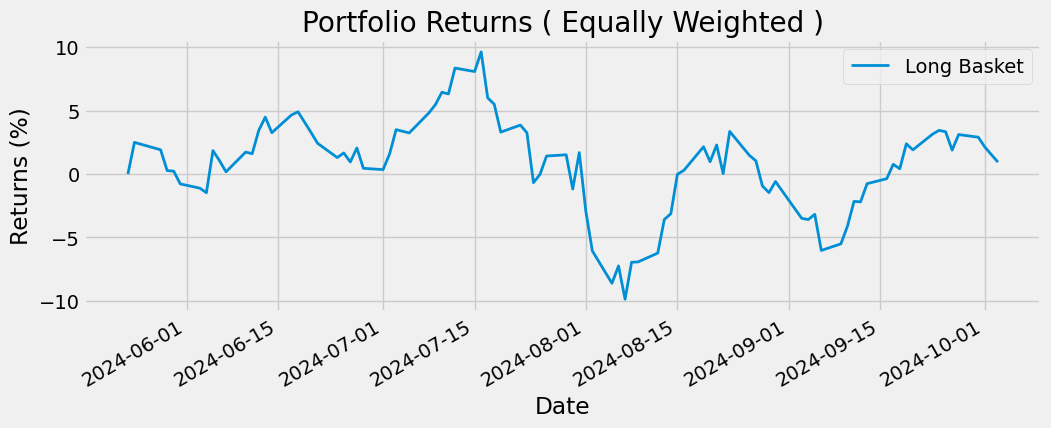

In [9]:
portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
portfolio_returns.plot(label='Long Basket', lw=2) 
plt.legend()
plt.title('Portfolio Returns ( Equally Weighted )')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.show()

In [10]:

portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
print("Portfolio Returns from Project Completion to Current Date:")
print (portfolio_returns)

current_date = datetime.now()
project_completion_date = datetime(2023, 11, 15)

# difference between the two dates
difference_days = current_date - project_completion_date 

# number of weeks
weeks = difference_days.days // 7
print (f"Avegare Weekly Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (portfolio_returns[-1]/weeks)

Portfolio Returns from Project Completion to Current Date:
Date
2024-05-23    0.000000
2024-05-24    2.493774
2024-05-28    1.908991
2024-05-29    0.271293
2024-05-30    0.226070
                ...   
2024-09-27    3.109171
2024-09-30    2.901121
2024-10-01    2.127180
2024-10-02    1.529447
2024-10-03    0.937609
Length: 92, dtype: float64
Avegare Weekly Portfolio Returns from Project Completion to Current Date (46 weeks): 
0.02038281355111006


In [11]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
841.187893627649
Short Basket Cumulative Returns: Most current day
-40.69270453056957
SP500 Cumulative Returns: Most current day
108.09205463584027


In [12]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-10-03 Long Basket has outperformed the SP500 by 733.0958389918087 percentage points
As of 2024-10-03 Short Basket has underperformed the SP500 by -148.78475916640986 percentage points


## Graphing the Back Tested Cumulative Returns

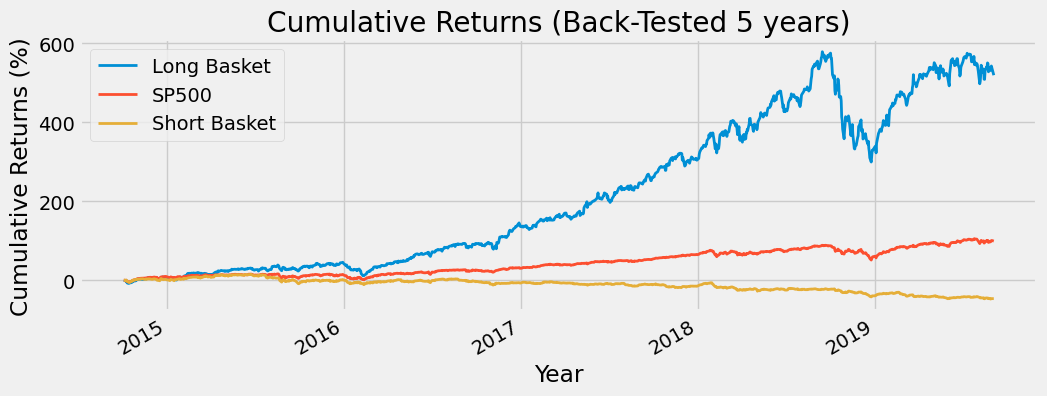

In [13]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Returns

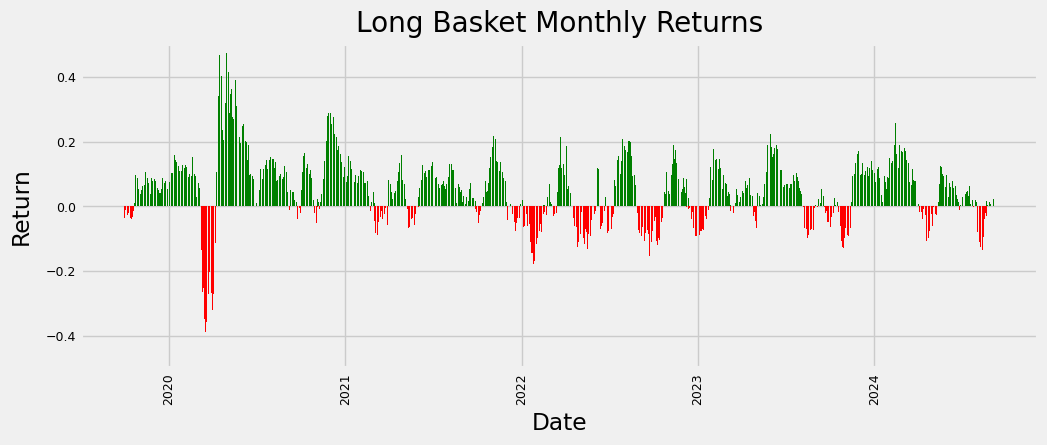

In [14]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

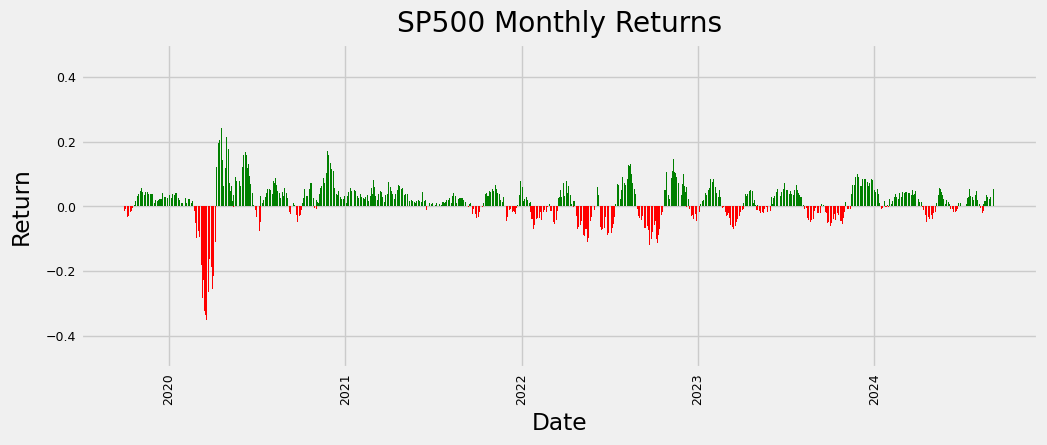

In [15]:
# Calculate 20-day ( monthly ) returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

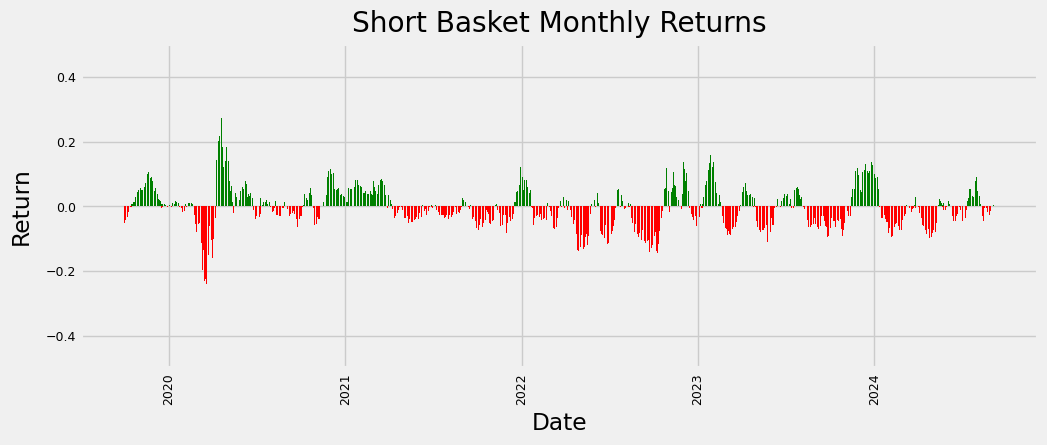

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Portfolio weights : 
#### My Efficient Frontier Program takes a basket of stocks and simulates over 200,000 times to find the arrangement of stock weights for our portfolio, that will return the highest earnings over risk-level.
#### You can find this program in the directory labeled Efficient_Frontier


# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [17]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-17] # slicing out the last 14 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [18]:
ef = EfficientFrontier(sp500[long_basket.index])
print('Annual Returns: Long Basket')
ef.calculate_portfolio() #Printing Annual Returns

Annual Returns: Long Basket
Ticker
NVDA    1.675643
SMCI    1.457766
TSLA    1.419324
NVR     1.259480
MRNA    1.466465
BLDR    1.487693
CRWD    1.465865
TRGP    1.213250
ENPH    1.536477
AZO     1.209655
dtype: float64


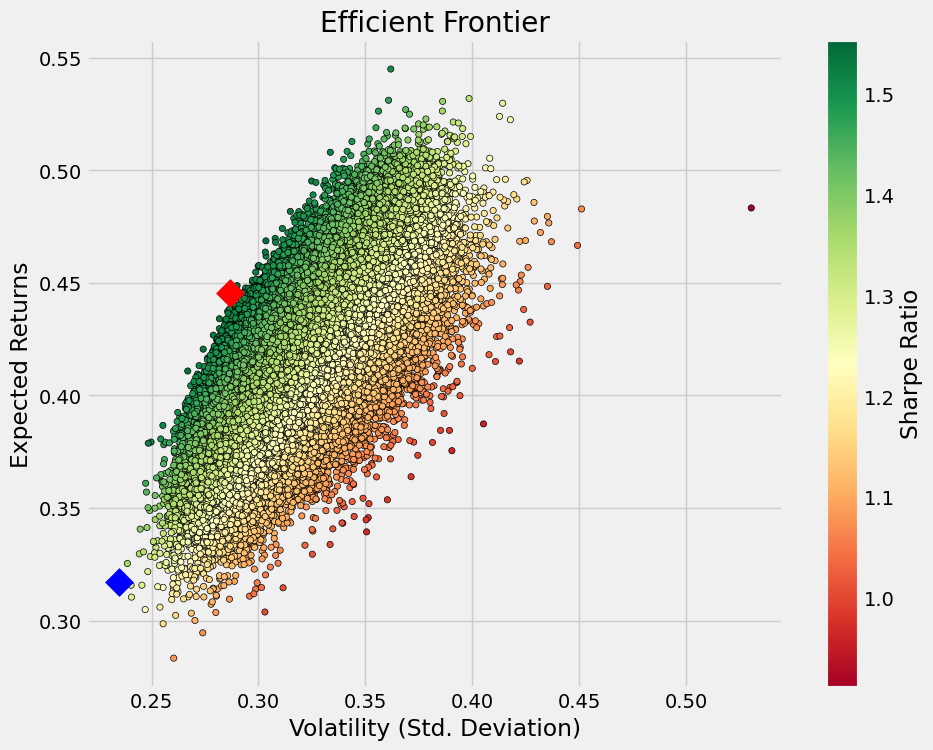

In [19]:
ef.plot_frontier() # Visualizes the simulations for our Long Basket portfolio
# With each dot representing a different portfolio, and the curve of the spread representing the efficient frontier

In [20]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.316998                  0.445530
Volatility                        0.234579                  0.286665
Sharpe Ratio                      1.351350                  1.554185
NVDA Weight                       0.060071                  0.296079
SMCI Weight                       0.017042                  0.007480
TSLA Weight                       0.057204                  0.056969
NVR Weight                        0.268332                  0.148776
MRNA Weight                       0.041872                  0.119992
BLDR Weight                       0.003880                  0.101924
CRWD Weight                       0.085601                  0.032003
TRGP Weight                       0.052444                  0.023509
ENPH Weight                       0.048363                  0.028317
AZO Weight                        0.365190                  0.184951


## Maximizing returns with our updated weights:

In [21]:
tickers_4_results = ['TSLA', 'MRNA', 'NVDA', 'SMCI', 'NVR', 'ENPH', 'BLDR', 'CMG', 'AZO', 'AMD']
current_date1 = datetime.now()
current_date = pd.Timestamp.now().strftime('%Y-%m-%d')
project_completion_date = datetime(2023, 11, 15)
yf_data = yf.download(tickers_4_results, start='2023-11-15', end=current_date)['Adj Close']
sp500 = yf.download(sp500_tickers, start='2023-11-15', end=current_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-11-15 -> 2024-10-03)')
['-', 'BRK.B', '2481632D']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [22]:

weights_maximum_risk = {
    'TSLA': 0.013270, 'MRNA': 0.155588, 'NVDA': 0.250389, 'SMCI': 0.150165,
    'NVR': 0.022550, 'ENPH': 0.073423, 'BLDR': 0.019092, 'CMG': 0.022661,
    'AZO': 0.244763, 'AMD': 0.048099
}


 # Calculate daily portfolio returns for both scenarios
portfolio_returns_sp500 = (sp500.pct_change()).mean(axis=1)
portfolio_returns_maximum_risk = (yf_data.pct_change() *pd.Series(weights_maximum_risk)).sum(axis=1)


# Calculate cumulative returns to see the overall performance
cumulative_returns_maximum_risk = ((1 + portfolio_returns_maximum_risk).cumprod() - 1)*100
cumulative_returns_trace_sp500 = ((1 + portfolio_returns_sp500).cumprod() - 1)*100




In [23]:

cumulative_returns_maximum_risk_df = cumulative_returns_maximum_risk.reset_index()
cumulative_returns_trace_sp500_df = cumulative_returns_trace_sp500.reset_index()

# trace for my port
trace_max_risk = go.Scatter(
    x=cumulative_returns_maximum_risk_df['Date'],
    y=cumulative_returns_maximum_risk_df[0],
    mode='lines+text',  # Add 'markers+text' to the mode
    name='My Portfolio',
    text=[None]*(len(cumulative_returns_maximum_risk_df[0])-1) + [f"{cumulative_returns_maximum_risk_df[0].iloc[-1]:.2f}%"],
    textposition="top center",  # Position the text above the marker
    textfont=dict(color='white', size = 20)  # Text color
)

# sp500 trace
trace_sp500 = go.Scatter(
    x=cumulative_returns_trace_sp500_df['Date'],
    y=cumulative_returns_trace_sp500_df[0],
    mode='lines+text',  # Add 'markers+text' to the mode
    name='SP500',
    text=[None]*(len(cumulative_returns_trace_sp500_df[0])-1) + [f"{cumulative_returns_trace_sp500_df[0].iloc[-1]:.2f}%"],
    textposition="top center",  # Position the text above the marker
    textfont=dict(color='white', size = 20)  # Text color
)


# Combine the traces into a list
data = [trace_max_risk, trace_sp500]

# Set the layout of the figure
layout = go.Layout(
    title=go.layout.Title(
        #text='Portfolio Cumulative Returns',
        #font=dict(color='white')  # Title color
    ),
    xaxis=dict(
        title='Date',
        showgrid=False,  # Turns off the x-axis gridlines
        tickfont=dict(color='white'),  # X-axis ticks color
        title_font=dict(color='white')  # X-axis title color
    ),
    yaxis=dict(
        title='Cumulative Returns (%)',
        showgrid=False,  # Turns off the y-axis gridlines
        tickfont=dict(color='white'),  # Y-axis ticks color
        title_font=dict(color='white')  # Y-axis title color
    ),
    legend=dict(
        x=0,
        y=1.2,
        orientation='h',
        font=dict(color='white')  # Legend text color
    ),
    paper_bgcolor='rgba(0,0,0,0)',  # Keep the background transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Keep the plot area background transparent
    autosize=False,
    width=900,
    height=500
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Plot the figure
fig.show()

In [25]:
print ("Max Risk portfolio returns:")
print (cumulative_returns_maximum_risk)

print (f"Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_maximum_risk[-1]/weeks)



Max Risk portfolio returns:
Date
2023-11-15     0.000000
2023-11-16    -0.229904
2023-11-17    -0.119414
2023-11-20     2.524052
2023-11-21     1.313790
                ...    
2024-09-26    57.269428
2024-09-27    58.374250
2024-09-30    57.874600
2024-10-01    54.624803
2024-10-02    54.319776
Length: 221, dtype: float64
Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date (46 weeks): 
1.1808646945802193
